## Content  
1. [Separate variants by pathogenicity value](#1.-Separate-variants-by-pathogenicity-value)
2. [Balance dataframes](#2.-Balance-dataframes)
3. [Visualize the distribution of cDNA positions relative to the transcripts boundaries](#3.-Visualize-the-distribution-of-cDNA-positions-relative-to-the-transcripts-boundaries)
4. [Get sequence context](#4.-Get-sequence-context)
5. [Build a sequence logo](#5.-Build-a-sequence-logo)
6. [Statistical comparison of positions in contexts](#6.-Statistical-comparison-of-positions-in-contexts)

In [1]:
import datetime
import json
from os.path import join

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from Bio.Seq import Seq
from pyfaidx import Fasta

from all_code import (
                        get_cdna_percentage,
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        get_context,
                        plot_p_values,
                        translate_context,
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

ClinVar does not contain transcripts for the variants, so first annotate the downloaded Clinvar file (GRCh38 version) with VEP. 

In [2]:
nmd_escape_df = pd.read_csv("data/nmd_escape_df.csv")

In [3]:
pat_nmd_escape = nmd_escape_df.query('AC < 2')

In [4]:
ben_nmd_escape = nmd_escape_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_esc_df` and `ben_nmd_escape` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_esc_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [5]:
clinvar_nmd_esc_df = pd.read_csv("data/clinvar_nmd_escape_df.csv")
clinvar_nmd_esc = clinvar_nmd_esc_df.rename(columns={'Feature': 'Canonical_transcript'})

In [6]:
merged_clinvar_and_ben = pd.concat([ben_nmd_escape, clinvar_nmd_esc], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,12011511,rs1060501925,G,A,HIGH,stop_gained,MFN2,ENST00000235329,2410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1451,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1452,chr22,50731088,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5050,...,988471.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1453,chr22,50731100,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5062,...,992589.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [7]:
# remove duplicates
ben_nmd_escape_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chr1,19258756,.,C,T,HIGH,stop_gained,MRTO4,ENST00000330263,677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1451,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1452,chr22,50731088,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5050,...,988471.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1453,chr22,50731100,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5062,...,992589.0,Pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [8]:
# remove the Clinvar df
ben_nmd_escape_filtered = ben_nmd_escape_filtered[~ben_nmd_escape_filtered['CLNSIG'].notna()]
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chr1,19258756,.,C,T,HIGH,stop_gained,MRTO4,ENST00000330263,677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,chr22,27854918,rs1354485787,G,A,HIGH,stop_gained,PITPNB,ENST00000335272,855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ben_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type',
       'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [10]:
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7.0,0.245,1.000000,YES
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3.0,0.194,0.950938,YES
3,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,HC,NaN,NaN,3.0,0.274,0.997337,YES
4,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,HC,NaN,NaN,57.0,0.274,0.997337,YES
5,chr1,19258756,.,C,T,HIGH,stop_gained,MRTO4,ENST00000330263,677,HC,NaN,NaN,4.0,0.230,0.823157,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,chr22,27854918,rs1354485787,G,A,HIGH,stop_gained,PITPNB,ENST00000335272,855,HC,NaN,NaN,2.0,0.287,0.825734,YES
724,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,HC,NaN,NaN,10.0,0.086,0.585560,YES
725,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,0.996598,YES
726,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,0.988884,YES


Before filtering:

In [11]:
ben_nmd_escape.shape

(728, 17)

**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_escape` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [12]:
pat_nmd_escape.shape[0] + clinvar_nmd_esc.shape[0]

2435

In [13]:
merged_clinvar_and_pat = pat_nmd_escape.merge(clinvar_nmd_esc, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2392,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2393,chr9,134842172,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771.0,YES,0.055,0.72251,YES,right_only
2394,chr9,134842211,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5810.0,YES,0.055,0.72251,YES,right_only


In [14]:
pat_nmd_escape_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [15]:
duplicates = pat_nmd_escape_filtered[pat_nmd_escape_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [16]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [17]:
pat_nmd_escape_filtered['Canonical_transcript_x'] = pat_nmd_escape_filtered['Canonical_transcript_x'].fillna(pat_nmd_escape_filtered['Canonical_transcript_y'])
pat_nmd_escape_filtered['cDNA_position_x'] = pat_nmd_escape_filtered['cDNA_position_x'].fillna(pat_nmd_escape_filtered['cDNA_position_y'])
pat_nmd_escape_filtered['Consequence_x'] = pat_nmd_escape_filtered['Consequence_x'].fillna(pat_nmd_escape_filtered['Consequence_y'])
pat_nmd_escape_filtered['LOEUF_x'] = pat_nmd_escape_filtered['LOEUF_x'].fillna(pat_nmd_escape_filtered['LOEUF_y'])
pat_nmd_escape_filtered['Gene_symbol'] = pat_nmd_escape_filtered['Gene_symbol'].fillna(pat_nmd_escape_filtered['SYMBOL'])
pat_nmd_escape_filtered['NMD_escape_x'] = pat_nmd_escape_filtered['NMD_escape_x'].fillna(pat_nmd_escape_filtered['NMD_escape_y'])
pat_nmd_escape_filtered['pext_x'] = pat_nmd_escape_filtered['pext_x'].fillna(pat_nmd_escape_filtered['pext_y'])

In [18]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [19]:
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_escape_filtered = pat_nmd_escape_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439.0,HC,NaN,NaN,1.0,0.194,0.950938,YES
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558.0,HC,NaN,NaN,1.0,0.194,0.950938,YES
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570.0,HC,NaN,NaN,1.0,0.194,0.950938,YES
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577.0,HC,NaN,NaN,1.0,0.194,0.950938,YES
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594.0,HC,NaN,NaN,1.0,0.194,0.950938,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152.0,HC,NaN,NaN,1.0,0.118,0.787313,YES
2392,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644.0,HC,NaN,NaN,1.0,0.341,0.546637,YES
2393,chr9,134842172,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5771.0,NaN,NaN,NaN,NaN,0.055,0.722510,YES
2394,chr9,134842211,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5810.0,NaN,NaN,NaN,NaN,0.055,0.722510,YES


In [20]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [21]:
pat_nmd_escape.shape

(1708, 17)

**The dataframe with pathogenic variants is ready.**

## 2. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_escape_filtered` and `pat_nmd_escape_filtered`, and also equalize the number of variants in each gene.

In [22]:
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 725
Unique genes in ben dataframe: 419
Intersected genes: 327


In [23]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_escape_filtered = ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_escape_filtered = pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]

In [24]:
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 327
Unique genes in ben dataframe: 327
Intersected genes: 327


In [25]:
count_pat = pat_nmd_escape_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_escape_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_escape_final = pd.concat([
    pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_escape_final = pd.concat([
    ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [26]:
pat_nmd_escape_final.shape == ben_nmd_escape_final.shape

True

In [27]:
pat_nmd_escape_final['Gene_symbol'].nunique() == ben_nmd_escape_final['Gene_symbol'].nunique()

True

In [28]:
pat_nmd_escape_final['Gene_symbol'].value_counts().sum() == ben_nmd_escape_final['Gene_symbol'].value_counts().sum()

True

In [29]:
pat_nmd_escape_final['Gene_symbol'].nunique()

327

Dataframes are now balanced by genes and number of variants.

## 3. Visualize the distribution of cDNA positions relative to the transcripts boundaries

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [30]:
pat_nmd_escape_final['Percent_position'] = pat_nmd_escape_final.apply(get_cdna_percentage, axis=1)
ben_nmd_escape_final['Percent_position'] = ben_nmd_escape_final.apply(get_cdna_percentage, axis=1)

Visualize the distribution of variants.

In [31]:
pat_nmd_escape_final_sorted = pat_nmd_escape_final.copy()
pat_nmd_escape_final_sorted['CHROM'] = pat_nmd_escape_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_escape_final_sorted = pat_nmd_escape_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [32]:
ben_nmd_escape_final_sorted = ben_nmd_escape_final.copy()
ben_nmd_escape_final_sorted['CHROM'] = ben_nmd_escape_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_escape_final_sorted = ben_nmd_escape_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

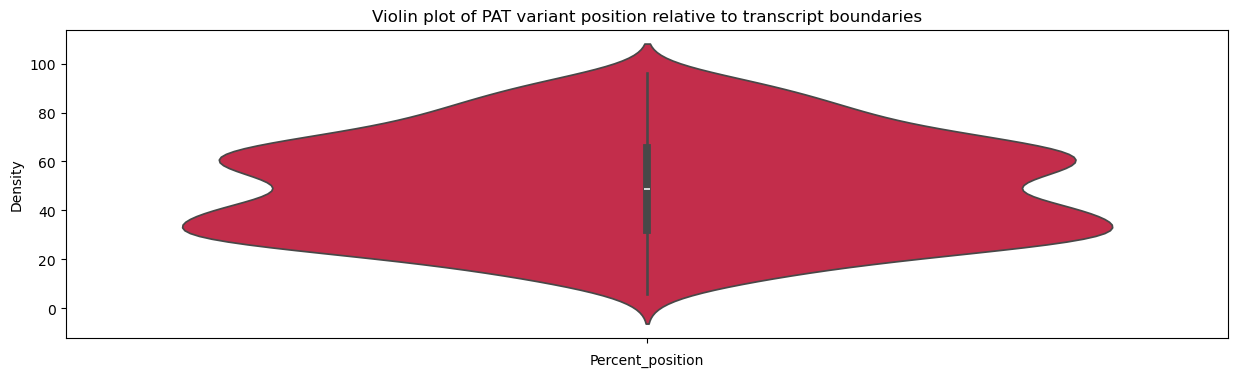

In [33]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

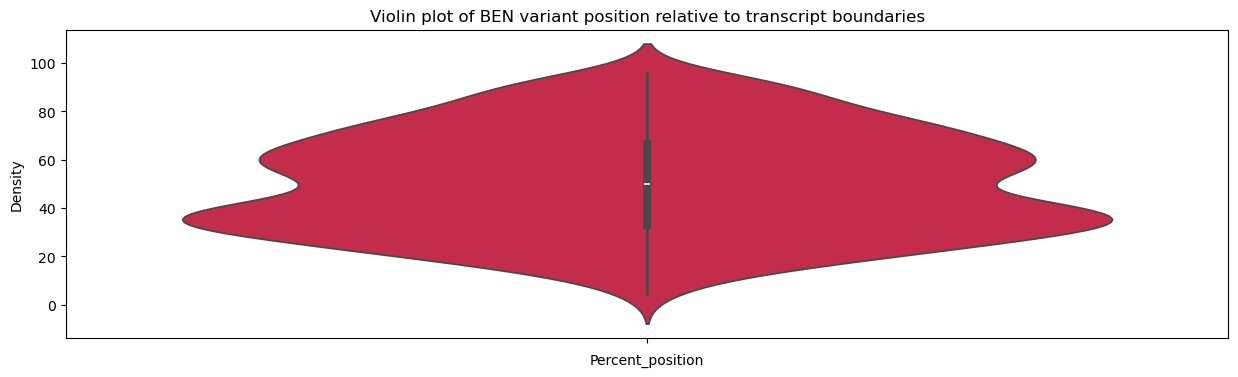

In [34]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

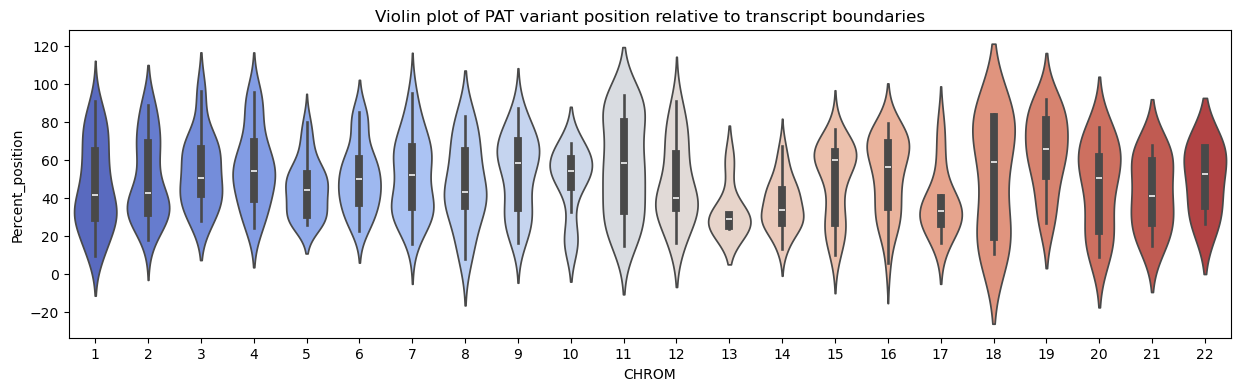

In [35]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

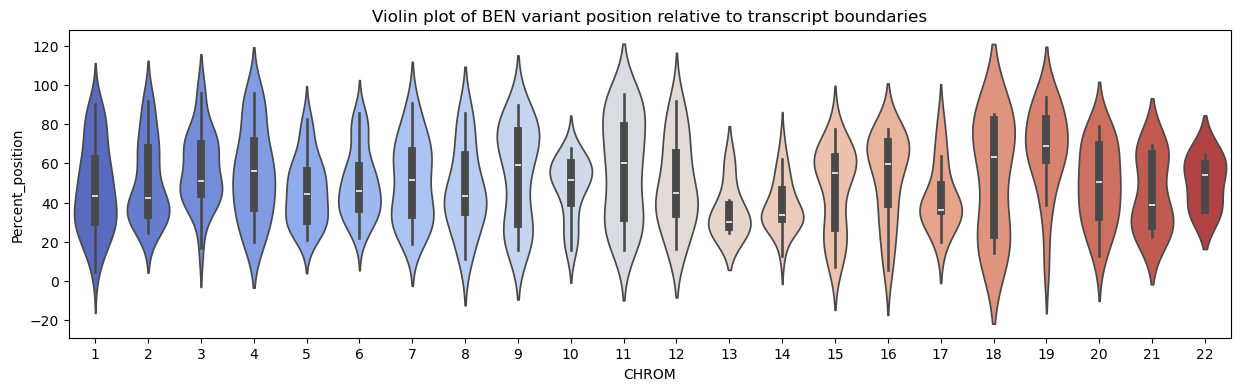

In [36]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

In [37]:
# plt.figure(figsize=(15, 4))
# sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
# plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
# plt.xlabel('Codon_position')
# plt.ylabel('Percent_position')
# plt.show()

In [38]:
# plt.figure(figsize=(15, 4))
# sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
# plt.title('Violin plot of BEN variant position relative to transcript boundaries')
# plt.xlabel('Codon_position')
# plt.ylabel('Percent_position')
# plt.show()

## 4. Get sequence context

Write the context in the corresponding column of the dataframe.

In [39]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Divide dataframes by variant position in a codon.

In [40]:
# ben_nmd_escape_final_1 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 1].copy()
# ben_nmd_escape_final_2 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 2].copy()
# ben_nmd_escape_final_3 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 3].copy()

In [41]:
# pat_nmd_escape_final_1 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 1].copy()
# pat_nmd_escape_final_2 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 2].copy()
# pat_nmd_escape_final_3 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 3].copy()

Get contexts.

In [42]:
pat_nmd_escape_final

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Percent_position
1867,chr6,7583197,.,C,T,HIGH,stop_gained,DSP,ENST00000379802,6180.0,HC,NaN,NaN,1.0,0.260,0.999478,YES,63.731051
1897,chr6,7585276,NaN,C,T,NaN,stop_gained,DSP,ENST00000379802,8259.0,NaN,NaN,NaN,NaN,0.260,0.999478,YES,85.170671
1896,chr6,7585222,NaN,C,T,NaN,stop_gained,DSP,ENST00000379802,8205.0,NaN,NaN,NaN,NaN,0.260,0.999478,YES,84.613798
1979,chr6,87261014,.,C,A,HIGH,stop_gained,ZNF292,ENST00000369577,7412.0,HC,NaN,NaN,1.0,0.140,0.948588,YES,60.059963
1037,chr18,33745570,.,C,T,HIGH,stop_gained,ASXL3,ENST00000269197,6135.0,HC,NaN,NaN,1.0,0.199,0.811312,YES,52.168367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,chr14,91877538,NaN,A,C,NaN,stop_gained,FBLN5,ENST00000342058,1599.0,NaN,NaN,NaN,NaN,0.172,0.788355,YES,60.914286
1756,chr5,138933826,.,C,T,HIGH,stop_gained,CTNNA1,ENST00000302763,2546.0,HC,NaN,NaN,1.0,0.313,0.790800,YES,67.820991
1755,chr5,137625796,rs2149876234,C,T,HIGH,stop_gained,KLHL3,ENST00000309755,2135.0,HC,NaN,NaN,1.0,0.337,0.890699,YES,31.373990
426,chr11,77666973,.,C,A,HIGH,stop_gained,RSF1,ENST00000308488,4278.0,HC,NaN,NaN,1.0,0.044,0.711836,YES,38.053727


In [43]:
def get_context(df: pd.DataFrame, transcript_fasta: dict, left_len: int, right_len: int) -> str:
    """
    Add sequences context to the dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing transcript and position information.
        transcript_fasta (dict): A dictionary containing transcript sequences.
        left_len (int): The length of the left flanking region.
        right_len (int): The length of the right flanking region.

    Returns:
        str: A message indicating that contexts have been added to the dataframe.
    """
    contexts = []

    for index, row in df.iterrows():
        transcript_id = row['Canonical_transcript']
        position_of_interest = row['cDNA_position']

        if transcript_id in transcript_fasta:
            transcript_length = len(transcript_fasta[transcript_id])

            if left_len < position_of_interest < transcript_length - right_len:
                sequence_of_interest = str(transcript_fasta[transcript_id][int(position_of_interest) - int(left_len): int(position_of_interest) + int(right_len)])
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None
        
        contexts.append(sequence_of_interest)

    df['Context'] = contexts
    message = 'Contexts have been added to the dataframe!'

    return message

In [44]:
get_context(ben_nmd_escape_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [45]:
get_context(pat_nmd_escape_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [83]:
def check_ref_match(row):
    transcript_id = row['Canonical_transcript']
    cDNA_position = row['cDNA_position']
    variant = str(row['Context'][12])
    ref = row['REF']

    complement_bases = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    if transcript_id in transcript_fasta:
        fasta_sequence = str(transcript_fasta[transcript_id][int(cDNA_position) - 1])

        if variant == fasta_sequence and variant == ref:
            return '+'
        elif variant == fasta_sequence == fasta_sequence and variant == complement_bases.get(ref):
            return '-'
        else:
            return 'No'
    else:
        return 'No'


In [79]:
pat_nmd_escape_final['Strand'] = pat_nmd_escape_final.apply(check_ref_match, axis=1)
pat_nmd_escape_final['Strand'].value_counts()

Strand
-     276
+     257
No      3
Name: count, dtype: int64

In [80]:
ben_nmd_escape_final['Strand'] = ben_nmd_escape_final.apply(check_ref_match, axis=1)
ben_nmd_escape_final['Strand'].value_counts()

Strand
-     276
+     258
No      2
Name: count, dtype: int64

In [81]:
pat_nmd_escape_final = pat_nmd_escape_final[pat_nmd_escape_final['Strand'] != 'No']
ben_nmd_escape_final = ben_nmd_escape_final[ben_nmd_escape_final['Strand'] != 'No']

In [84]:
ben_nmd_escape_final

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Percent_position,Context,Strand
248,chr6,7583872,rs876657798,C,T,HIGH,stop_gained,DSP,ENST00000379802,6855,HC,NaN,NaN,2.0,0.260,0.999478,YES,70.691967,TTGCTTTCAGTACAGAAGAGAAGCA,+
250,chr6,7584262,rs369482721,C,T,HIGH,stop_gained,DSP,ENST00000379802,7245,HC,NaN,NaN,3.0,0.260,0.999478,YES,74.713829,CTGTCTGCAGAACGAGCTGTCACTG,+
251,chr6,7584631,.,C,T,HIGH,stop_gained,DSP,ENST00000379802,7614,HC,NaN,NaN,2.0,0.260,0.999478,YES,78.519130,GTGCAGACATCACAAAAGAATACCC,+
276,chr6,87256319,rs76661125,C,A,HIGH,stop_gained,ZNF292,ENST00000369577,2717,HC,NaN,NaN,7.0,0.140,0.948588,YES,22.016044,GCAAAGCAGAATCAGCTGTGACCAA,+
652,chr18,33746590,rs1268450717,C,T,HIGH,stop_gained,ASXL3,ENST00000269197,7155,HC,NaN,NaN,3.0,0.199,0.811312,YES,60.841837,TGCCTGGTTGTACGATAAGAGCTGA,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,chr14,91877501,rs80338767,C,A,HIGH,stop_gained,FBLN5,ENST00000342058,1636,HC,NaN,NaN,2.0,0.172,0.788355,YES,62.323810,AATGAGGGCAGAGAATTTTACATGC,-
223,chr5,138933988,.,A,T,HIGH,stop_gained,CTNNA1,ENST00000302763,2708,HC,NaN,NaN,2.0,0.313,0.790800,YES,72.136388,GTGAAGAGAGAGAAACAGGATGAGA,+
222,chr5,137625797,.,C,T,HIGH,stop_gained,KLHL3,ENST00000309755,2134,HC,NaN,NaN,2.0,0.337,0.890699,YES,31.359295,TCACTGACAAATGGACGCTGCTTCC,-
473,chr11,77666925,rs1342555843,G,A,HIGH,stop_gained,RSF1,ENST00000308488,4326,HC,NaN,NaN,2.0,0.044,0.711836,YES,38.480697,TGTAACAGTGAACAGTTATAAGACT,-


In [93]:
transcript_fasta['ENST00000379802'][6855 - 1]

>ENST00000379802:6855-6855
C

In [94]:
transcript_fasta['ENST00000379802'][6855 - 13 : 6855 + 12]

>ENST00000379802:6843-6867
TTGCTTTCAGTACAGAAGAGAAGCA

In [95]:
transcript_fasta['ENST00000379802'][6855 - 13 : 6855 + 12][12]  # целевая точка нахоится на 12 индексе

>ENST00000379802:6855-6855
C

In [96]:
def update_codon_position(row):
    context = row['Context']
    strand = row['Strand']
    alt = row['ALT']
    complement_bases = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    if strand == '+':
        # меняем симвлом с индексом 12
        updated_context = context[:12] + alt + context[13:]
    elif strand == '-':
        complement_alt = complement_bases.get(alt)
        updated_context = context[:12] + complement_alt + context[13:]
    else:
        return 'No'
    
    codon_10_11_12 = updated_context[10:13]
    codon_11_12_13 = updated_context[11:14]
    codon_13_14_15 = updated_context[13:16]
    
    if codon_10_11_12 in ['TAA', 'TAG', 'TGA']:
        return 3
    elif codon_11_12_13 in ['TAA', 'TAG', 'TGA']:
        return 2
    elif codon_13_14_15 in ['TAA', 'TAG', 'TGA']:
        return 1
    else:
        return 'No'

In [97]:
pat_nmd_escape_final['Codon_position'] = pat_nmd_escape_final.apply(update_codon_position, axis=1)
pat_nmd_escape_final['Codon_position'].value_counts()

/tmp/ipykernel_1086019/3059240737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat_nmd_escape_final['Codon_position'] = pat_nmd_escape_final.apply(update_codon_position, axis=1)


Codon_position
No    346
2     102
3      85
Name: count, dtype: int64

In [98]:
ben_nmd_escape_final['Codon_position'] = ben_nmd_escape_final.apply(update_codon_position, axis=1)
ben_nmd_escape_final['Codon_position'].value_counts()

/tmp/ipykernel_1086019/1772448543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ben_nmd_escape_final['Codon_position'] = ben_nmd_escape_final.apply(update_codon_position, axis=1)


Codon_position
No    389
2      80
3      65
Name: count, dtype: int64

## 5. Build a sequence logo

In [54]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_escape_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_escape_final_3['Context'])

NameError: name 'ben_nmd_escape_final_1' is not defined

In [ ]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_escape_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_escape_final_3['Context'])

In [ ]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_1, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-9, 12))
pat_logo.ax.set_title('Context for the pathogenic variant in 1st codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_1, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-9, 12))
ben_logo.ax.set_title('Context for the benign variant in 1st codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/1st_pos_context_nmd_escape.png', bbox_inches='tight')

In [ ]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_2, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-10, 11))
pat_logo.ax.set_title('Context for the pathogenic variant in 2nd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_2, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-10, 11))
ben_logo.ax.set_title('Context for the benign variant in 2nd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/2nd_pos_context_nmd_escape.png', bbox_inches='tight')

In [ ]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_3, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-11, 10))
pat_logo.ax.set_title('Context for the pathogenic variant in 3rd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_3, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-11, 10))
ben_logo.ax.set_title('Context for the benign variant in 3rd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/3rd_pos_context_nmd_escape.png', bbox_inches='tight')

## 6. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [ ]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 9:
        print("==="*25)
    if counter == 10:
        print("==="*25)

In [ ]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 10:
        print("==="*25)
    if counter == 11:
        print("==="*25)

In [ ]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 11:
        print("==="*25)
    if counter == 12:
        print("==="*25)

In [ ]:
positions_1, positions_2, positions_3 = list(range(-9, 12)), list(range(-10, 11)), list(range(-11, 10))

In [ ]:
positions_list = [positions_1, positions_2, positions_3]
p_values_list = [p_values_1, p_values_2, p_values_3]

plot_p_values(positions_list, p_values_list)

# plt.savefig('images/p_values_nmd_escape_plot.png')
# plt.show()

### Посмотрим на аминокислоты в округе

Краткий пример, что сделала по аминокислотам. Надо будет ещё навести красоту, но как будто бы какая-то фигня вышла всё равно.

In [ ]:
transcript_fasta['ENST00000398473'][2209 - 10 : 2209 + 11]  # CAG  5|7 (1 позиция)

In [ ]:
my_rna = Seq("ATCAGGGAACAGAGACGCCAG")
my_aa = my_rna.translate()
my_aa

In [ ]:
# здесь просто добавила по 90 букв к каждой границе, чтобы вывести в итоге равное количество аминокислот 
# вне зависимости от позиции варианта в кодоне

get_context(ben_nmd_escape_final_1, transcript_fasta, 10+90, 11+90)
get_context(ben_nmd_escape_final_2, transcript_fasta, 11+90, 10+90)
get_context(ben_nmd_escape_final_3, transcript_fasta, 12+90, 9+90)

get_context(pat_nmd_escape_final_1, transcript_fasta, 10+90, 11+90)
get_context(pat_nmd_escape_final_2, transcript_fasta, 11+90, 10+90)
get_context(pat_nmd_escape_final_3, transcript_fasta, 12+90, 9+90)

Для аминокислотного контекста я пыталась выровнять количество аминокислот вокруг целевого кодона, учитывая при этом, что у нас датафреймы разделены по позиции. Получилось равное количество остатков для всех датафреймов (67).

In [ ]:
len(pat_nmd_escape_final_1.loc[2315]['Context']) / 3

In [ ]:
len(pat_nmd_escape_final_2.loc[1979]['Context']) / 3

In [ ]:
len(pat_nmd_escape_final_3.loc[1867]['Context']) / 3

**Позиция в кодоне 1:**  

**33 позиция на лого**

In [ ]:
pat_nmd_escape_final_1['AA_context'] = translate_context(pat_nmd_escape_final_1['Context'])
ben_nmd_escape_final_1['AA_context'] = translate_context(ben_nmd_escape_final_1['Context'])

In [ ]:
filtered_aa_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['AA_context'])
filtered_aa_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['AA_context'])

In [ ]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_aa_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_1 = lm.alignment_to_matrix(filtered_aa_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 2:**  
  
**33 позиция на лого**

In [ ]:
pat_nmd_escape_final_2['AA_context'] = translate_context(pat_nmd_escape_final_2['Context'])
ben_nmd_escape_final_2['AA_context'] = translate_context(ben_nmd_escape_final_2['Context'])

In [ ]:
filtered_aa_context_pat_2 = filter_and_convert_to_list(pat_nmd_escape_final_2['AA_context'])
filtered_aa_context_ben_2 = filter_and_convert_to_list(ben_nmd_escape_final_2['AA_context'])

In [ ]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_aa_context_pat_2)
pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_2 = lm.alignment_to_matrix(filtered_aa_context_ben_2)
ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Позиция в кодоне 3:**

**Я в замешательстве -- здесь бОльшие изменения видны не на 33 позиции, как должно быть, а на 34 -_-**

In [ ]:
pat_nmd_escape_final_3['AA_context'] = translate_context(pat_nmd_escape_final_3['Context'])
ben_nmd_escape_final_3['AA_context'] = translate_context(ben_nmd_escape_final_3['Context'])

In [ ]:
filtered_aa_context_pat_3 = filter_and_convert_to_list(pat_nmd_escape_final_3['AA_context'])
filtered_aa_context_ben_3 = filter_and_convert_to_list(ben_nmd_escape_final_3['AA_context'])

In [ ]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_aa_context_pat_3)
pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_3 = lm.alignment_to_matrix(filtered_aa_context_ben_3)
ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

**Дальше я попробовала сконкатенировать датафреймы, но в итоге вышло не очень красиво и понятно:**

In [ ]:
pat_concatenated_df = pd.concat([pat_nmd_escape_final_1, pat_nmd_escape_final_2, pat_nmd_escape_final_3])
ben_concatenated_df = pd.concat([ben_nmd_escape_final_1, ben_nmd_escape_final_2, ben_nmd_escape_final_3])

In [ ]:
filtered_aa_context_pat = filter_and_convert_to_list(pat_concatenated_df['AA_context'])
filtered_aa_context_ben = filter_and_convert_to_list(ben_concatenated_df['AA_context'])

In [ ]:
counts_mat_pat = lm.alignment_to_matrix(filtered_aa_context_pat)
pat_logo = lm.Logo(counts_mat_pat, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben = lm.alignment_to_matrix(filtered_aa_context_ben)
ben_logo = lm.Logo(counts_mat_ben, 
                   figsize=(15, 2),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')